# Dataset Preparation for Canada Population Statistics

Using the Kontur Population Dataset in GPKG format, we will filter and prepare population data specifically for Canada.
The [Canada GeoJSON](./inputs/canada.geojson) will be used to define the geographic extent for filtering.

Data can be found at: https://data.humdata.org/dataset/kontur-population-dataset

Once the data is filtered, we will quantize it for lower H3 resolutions using available ones.

Finally, we will save it in GeoParquet format for efficient storage and further analysis.
The analysis will focus on different possible representations of the columnar data and its impact on storage size.


In [3]:
from shapely.geometry import box
import geopandas as gpd
import pandas as pd
import h3pandas  # noqa  # unused directly, but init '.h3' accessor
import h3
import matplotlib.pyplot as plt
import fiona
import os

In [80]:
# Check available layers in the GPKG
layers = fiona.listlayers('kontur_population_20231101.gpkg')
print('Available layers in GPKG:', layers)

Available layers in GPKG: ['population']


In [81]:
# Load Canada GeoJSON (only to get the bounding box)
canada_gdf = gpd.read_file('canada.geojson')
print('Canada GeoJSON CRS:', canada_gdf.crs)

# Check CRS of GPKG (using first layer)
with fiona.open('kontur_population_20231101.gpkg', layer=layers[0]) as src:
    print('Kontur Population CRS:', src.crs)

Canada GeoJSON CRS: EPSG:4326
Kontur Population CRS: EPSG:3857


In [4]:
# If CRS do not match, reproject bbox to GPKG CRS
kontur_population_crs = src.crs['init'] if 'init' in src.crs else src.crs.get('epsg')
if str(canada_gdf.crs).lower() != str(kontur_population_crs).lower():
    canada_gdf = canada_gdf.to_crs(kontur_population_crs)
    print('Reprojected Canada GeoJSON to match GPKG CRS')

canada_bbox = tuple(canada_gdf.total_bounds)  # [minx, miny, maxx, maxy] as tuple
bbox_geom = box(*canada_bbox)
print('Canada bounding box:', canada_bbox)

Reprojected Canada GeoJSON to match GPKG CRS
Canada bounding box: (np.float64(-15696667.555570941), np.float64(5111538.235918922), np.float64(-5857290.160136116), np.float64(17929238.839123107))


## Pre-filter Kontur GPKG by Canada bounding box

Using a bounding box to pre-filter reduces the number of features read into memory.
This avoids processing the more complex intersection of polygon geometries for every feature in the dataset.
It also allows us to perform CRS alignment and visualize quickly the expected subset result.

In [5]:
kontur_gdf_bbox = gpd.read_file(
    'kontur_population_20231101.gpkg',
    layer=layers[0],
    bbox=canada_bbox
)

print(f'Features after bbox filter: {len(kontur_gdf_bbox)}')


Features after bbox filter: 1846637


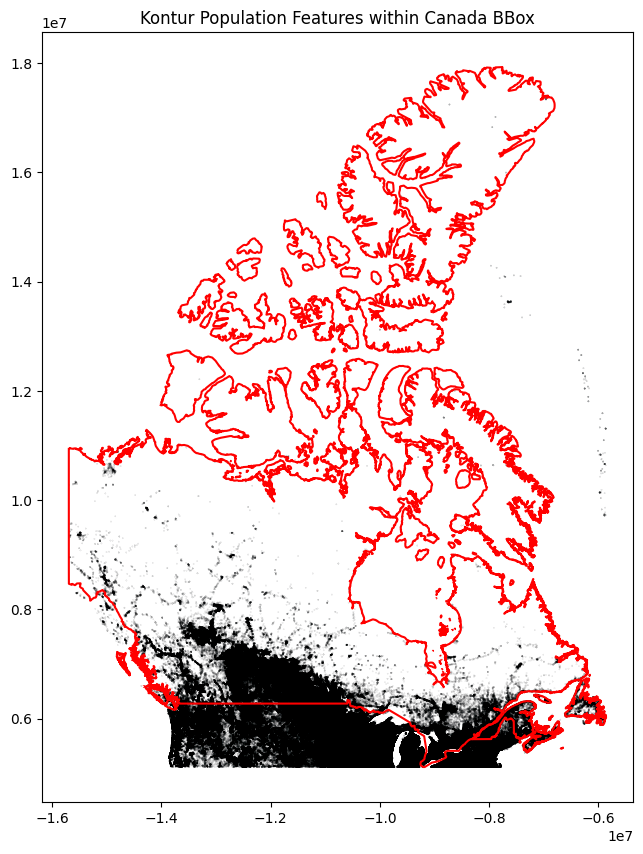

In [6]:
# Visualize the pre-filtered features
ax = kontur_gdf_bbox.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
canada_gdf.boundary.plot(ax=ax, color='red')
plt.title('Kontur Population Features within Canada BBox')
plt.show()


# Further filter by actual Canada polygon

In [ ]:
population_canada_gdf = kontur_gdf_bbox.clip(canada_gdf)
# Visualize the final filtered features
ax = population_canada_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
canada_gdf.boundary.plot(ax=ax, color='red')
plt.title('Kontur Population Features within Canada Polygon')
plt.show()

In [ ]:
# fix type
population_canada_gdf['population'] = population_canada_gdf['population'].astype('int32')

In [11]:
# Save the filtered features to a GeoParquet file
population_canada_gdf.to_parquet('h3_population_canada_2023-11-01.parquet')

In [15]:
population_canada_gdf

,h3,population,geometry
1168470,88271c69cdfffff,1,"POLYGON ((-10928896.16 6273960.683, -10928195...."
1168472,88271c69c9fffff,1,"POLYGON ((-10927439.922 6273995.372, -10926739..."
1168548,88271c6835fffff,2,"POLYGON ((-10925983.589 6274029.813, -10925282..."
1168555,88271c6813fffff,1,"POLYGON ((-10920157.315 6274165.086, -10919455..."
1153519,88271ea0b9fffff,1,"POLYGON ((-10964632.531 6274283.204, -10963934..."
...,...,...,...
1846391,8803716201fffff,5,"POLYGON ((-6940908.131 17380884.596, -6945033...."
1846388,8803716209fffff,8,"POLYGON ((-6938647.523 17384238.342, -6940514...."
1846383,8803716247fffff,4,"POLYGON ((-6938250.802 17390986.835, -6940119...."
1846382,8803716249fffff,1,"POLYGON ((-6927307.664 17401023.396, -6925032...."


In [16]:
print("Kontur Original Size:", os.stat('kontur_population_20231101.gpkg').st_size)
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01.parquet').st_size)

Kontur Original Size: 6711951360
Canada Filtered Size: 50087886


In [17]:
population_canada_gdf['population'].sum()

np.int64(38149423)

In [25]:
# Ensure 'population' column is int32
population_canada_df = population_canada_gdf.drop(columns=['geometry'])
population_canada_df.to_parquet('h3_population_canada_2023-11-01_no-geom.parquet')
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01_no-geom.parquet').st_size, "(no geometry)")

Canada Filtered Size: 6589273 (no geometry)


## Quantize Cells to Lower Resolutions and Storage Analysis

In [95]:
population_canada_df = population_canada_df.set_index('h3')
population_canada_df.to_parquet('h3_population_canada_2023-11-01_L8.parquet')
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01_L8.parquet').st_size, "(H3 only L8)")
population_canada_df.head(5)

Canada Filtered Size: 3929232 (H3 only L8)


,population
h3,
88271c69cdfffff,1
88271c69c9fffff,1
88271c6835fffff,2
88271c6813fffff,1
88271ea0b9fffff,1


In [93]:
display(population_canada_df.columns)
display(population_canada_df.index)
display(len(population_canada_df))

Index(['population'], dtype='object')

Index(['88271c69cdfffff', '88271c69c9fffff', '88271c6835fffff',
       '88271c6813fffff', '88271ea0b9fffff', '88271ea095fffff',
       '88271ea091fffff', '88271ea727fffff', '88271ea087fffff',
       '88271ea1a7fffff',
       ...
       '880371623bfffff', '8803716231fffff', '880371604bfffff',
       '8803716203fffff', '8803716205fffff', '8803716201fffff',
       '8803716209fffff', '8803716247fffff', '8803716249fffff',
       '880371624dfffff'],
      dtype='object', name='h3', length=591854)

591854

In [18]:
hex_population_canada_df = population_canada_df.reset_index()
hex_population_canada_df['h3'].dtype

dtype('O')

In [19]:
hex_population_canada_df.head(5)

,h3,population
0,88271c69cdfffff,1
1,88271c69c9fffff,1
2,88271c6835fffff,2
3,88271c6813fffff,1
4,88271ea0b9fffff,1


In [22]:
hex_population_canada_df['h3'] = hex_population_canada_df['h3'].apply(lambda zone_id: int(zone_id, 16))
display(hex_population_canada_df['h3'].dtype)
display(hex_population_canada_df.columns)

dtype('int64')

Index(['h3', 'population'], dtype='object')

In [12]:
hex_population_canada_df

,h3,population
0,613177597125197823,1
1,613177597121003519,1
2,613177596697378815,2
3,613177596661727231,1
4,613177749307129855,1
...,...,...
591849,612550117490163711,5
591850,612550117498552319,8
591851,612550117563564031,4
591852,612550117565661183,1


In [13]:
hex_population_canada_df.to_parquet('h3_population_canada_2023-11-01_L8-hex-int64.parquet')
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01_L8-hex-int64.parquet').st_size, "(H3 only L8, zone ID HEX->int64)")

Canada Filtered Size: 3503196 (H3 only L8, zone ID HEX->int64)


In [26]:
hex_population_canada_df = hex_population_canada_df.set_index('h3')
hex_population_canada_df.columns

Index(['population'], dtype='object')

In [27]:
hex_population_canada_df

,population
h3,
613177597125197823,1
613177597121003519,1
613177596697378815,2
613177596661727231,1
613177749307129855,1
...,...
612550117490163711,5
612550117498552319,8
612550117563564031,4


In [28]:
hex_population_canada_df.to_parquet('h3_population_canada_2023-11-01_L8-hex-int64-index.parquet')
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01_L8-hex-int64-index.parquet').st_size, "(H3 only L8, zone ID HEX->int64 + index)")

Canada Filtered Size: 3503033 (H3 only L8, zone ID HEX->int64 + index)


In [36]:
resolutions = population_canada_df.index.to_series().apply(h3.get_resolution).unique()
resolutions

array([8])

In [37]:
resolutions = reversed(range(0, max(resolutions)))
h3_canada_result = [population_canada_df]
agg_df = population_canada_df
for res in resolutions:
    print(f'Aggregating to resolution {res}')
    agg_df = agg_df.h3.h3_to_parent_aggregate(resolution=res, operation='sum')
    h3_canada_result.append(agg_df)

h3_population_canada_df = pd.concat(h3_canada_result)

Aggregating to resolution 7
Aggregating to resolution 6
Aggregating to resolution 5
Aggregating to resolution 4
Aggregating to resolution 3
Aggregating to resolution 2
Aggregating to resolution 1
Aggregating to resolution 0


In [82]:
h3_population_canada_df.drop(columns=['geometry'], inplace=True, errors='ignore')
print(f'Total cells after aggregation: {len(h3_population_canada_df)}')
h3_population_canada_df.head(5)

Total cells after aggregation: 862896


,population
88271c69cdfffff,1
88271c69c9fffff,1
88271c6835fffff,2
88271c6813fffff,1
88271ea0b9fffff,1


In [46]:
# sanity check
h3_population_canada_df['resolution'] = h3_population_canada_df.index.to_series().apply(h3.get_resolution)
h3_population_canada_df.groupby('resolution')['population'].sum()

resolution
0    38149423
1    38149423
2    38149423
3    38149423
4    38149423
5    38149423
6    38149423
7    38149423
8    38149423
Name: population, dtype: int32

In [83]:
h3_population_canada_df.drop(columns=['geometry', 'resolution'], inplace=True, errors='ignore')
h3_population_canada_df.to_parquet('h3_population_canada_2023-11-01_L0-L8.parquet')
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01_L0-L8.parquet').st_size, "(H3 L0 to L8)")

Canada Filtered Size: 5691187 (H3 L0 to L8)


In [62]:
idx_population_canada_df = h3_population_canada_df.drop(columns=['h3'], errors='ignore').reset_index(drop=True)
idx_population_canada_df.to_parquet('h3_population_canada_2023-11-01_L8-indices.parquet')
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01_L8-indices.parquet').st_size, "(H3 only L8, with offset index)")
idx_population_canada_df

Canada Filtered Size: 1128284 (H3 only L8, with offset index)


,population
0,1
1,1
2,2
3,1
4,1
...,...
862891,502087
862892,14
862893,2642222
862894,3901975


In [84]:
h3_population_canada_df

,population
88271c69cdfffff,1
88271c69c9fffff,1
88271c6835fffff,2
88271c6813fffff,1
88271ea0b9fffff,1
...,...
801bfffffffffff,502087
801dfffffffffff,14
8027fffffffffff,2642222
8029fffffffffff,3901975


In [78]:
idx_population_canada_df = h3_population_canada_df.drop(columns=['h3'], errors='ignore')
idx_population_canada_df['index'] = list(range(len(idx_population_canada_df)))
idx_population_canada_df = idx_population_canada_df.reset_index(drop=True)
idx_population_canada_df.to_parquet('h3_population_canada_2023-11-01_L8-indices.parquet')
print("Canada Filtered Size:", os.stat('h3_population_canada_2023-11-01_L8-indices.parquet').st_size, "(H3 only L8, with offset index)")
idx_population_canada_df

Canada Filtered Size: 4861264 (H3 only L8, with offset index)


,population,index
0,1,0
1,1,1
2,2,2
3,1,3
4,1,4
...,...,...
862891,502087,862891
862892,14,862892
862893,2642222,862893
862894,3901975,862894


In [89]:
h3_population_canada_df

,population
88271c69cdfffff,1
88271c69c9fffff,1
88271c6835fffff,2
88271c6813fffff,1
88271ea0b9fffff,1
...,...
801bfffffffffff,502087
801dfffffffffff,14
8027fffffffffff,2642222
8029fffffffffff,3901975
